In [1]:
import pandas as pd
import numpy as np
from pandas.errors import SettingWithCopyWarning
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Suppress copy warning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
# Read the data
df = pd.read_csv("train_data_initial.csv", parse_dates=["Unnamed: 0"]).rename(columns={"Unnamed: 0":"time"}).set_index("time")
df.head()

,Hour,Weekno,Enhanced_Weekday,gas_price,demand_2da,Solar7da,Wind7da,np15_outage_total,demandMinusWindMinusSolar,Ph,target0
time,,,,,,,,,,,
2023-07-16 01:00:00,2.0,28.0,7.0,7.99,28666.92,0.00,583.97,3027.39,28082.95,55.44675,51.02498
2023-07-16 02:00:00,3.0,28.0,7.0,7.99,27247.95,0.00,488.23,3008.23,26759.72,51.02498,49.36928
2023-07-16 03:00:00,4.0,28.0,7.0,7.99,26215.71,0.00,387.11,3030.13,25828.60,49.36928,48.37132
2023-07-16 04:00:00,5.0,28.0,7.0,7.99,25501.31,0.00,302.63,3020.09,25198.68,48.37132,49.89632
2023-07-16 05:00:00,6.0,28.0,7.0,7.99,24916.53,0.07,237.14,3839.71,24679.32,49.89632,49.93588


<Axes: title={'center': 'CAISO NP15 DAM Price'}, xlabel='time', ylabel='Price ($)'>

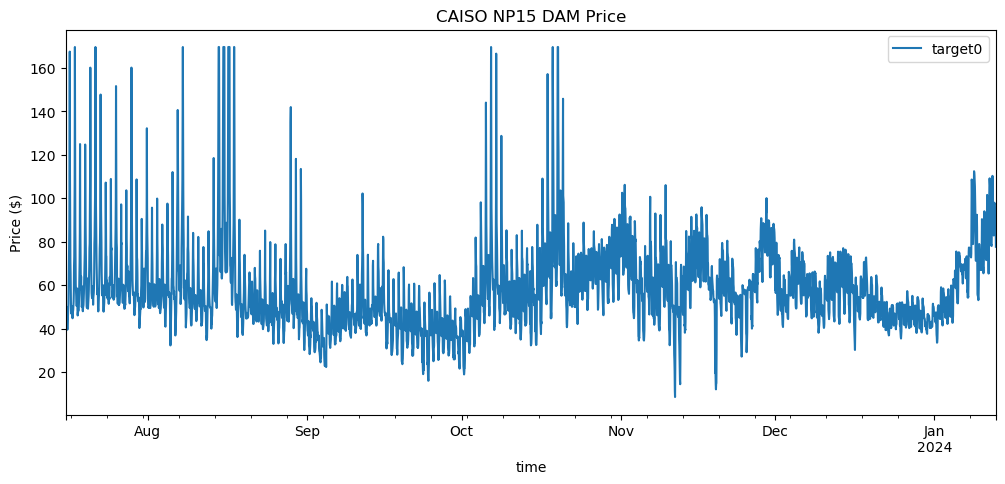

In [4]:
# Plot the price
df[["target0"]].plot(figsize=(12, 5), ylabel="Price ($)", title="CAISO NP15 DAM Price")

In [5]:
# Create a function for ts split
def get_ts_splits(df, splits):
    temp_df = df.copy(deep=True)
    
    X = temp_df.drop(["target0"], axis=1)
    y = temp_df.target0

    tss = TimeSeriesSplit(n_splits=splits)

    xtrain = []
    ytrain = []
    xtest = []
    ytest = []
    folds = []

    fold = 0
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index].to_frame(), y.iloc[test_index].to_frame()
        fold +=1
        X_train["fold"] = fold
        y_train["fold"] = fold
        X_test["fold"] = fold
        y_test["fold"] = fold
        xtrain.append(X_train)
        ytrain.append(y_train)
        xtest.append(X_test)
        ytest.append(y_test)
        print(f"Fold: {fold}")
        print(f"Train starts: {X_train[X_train.fold==fold].head(1).index[0]}, ends: {X_train[X_train.fold==fold].tail(1).index[0]}, size: {X_train[X_train.fold==fold].shape[0]}")
        print(f"Test starts: {X_test[X_test.fold==fold].head(1).index[0]}, ends: {X_test[X_test.fold==fold].tail(1).index[0]}, size: {X_test[X_test.fold==fold].shape[0]}")
        print("\n")
    
    train_x = pd.concat(xtrain)
    train_y = pd.concat(ytrain)
    test_x = pd.concat(xtest)
    test_y = pd.concat(ytest)
    return train_x, train_y, test_x, test_y

In [6]:
# Check the splits
train_x, train_y, test_x, test_y = get_ts_splits(df, 4)

Fold: 1
Train starts: 2023-07-16 01:00:00, ends: 2023-08-21 07:00:00, size: 871
Test starts: 2023-08-21 08:00:00, ends: 2023-09-26 11:00:00, size: 868


Fold: 2
Train starts: 2023-07-16 01:00:00, ends: 2023-09-26 11:00:00, size: 1739
Test starts: 2023-09-26 12:00:00, ends: 2023-11-01 15:00:00, size: 868


Fold: 3
Train starts: 2023-07-16 01:00:00, ends: 2023-11-01 15:00:00, size: 2607
Test starts: 2023-11-01 16:00:00, ends: 2023-12-07 19:00:00, size: 868


Fold: 4
Train starts: 2023-07-16 01:00:00, ends: 2023-12-07 19:00:00, size: 3475
Test starts: 2023-12-07 20:00:00, ends: 2024-01-12 23:00:00, size: 868




In [7]:
# Train on every folds with a model
def train(fold_num, model):
    x_train = train_x.query("fold==@fold_num").drop("fold", axis=1)
    y_train = train_y.query("fold==@fold_num").drop("fold", axis=1)
    x_test = test_x.query("fold==@fold_num").drop("fold", axis=1)
    y_test = test_y.query("fold==@fold_num").drop("fold", axis=1)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    mape = round(mean_absolute_percentage_error(y_test, pred), 4)
    print(f"MAPE for fold {fold_num}: {mape}")
    return mape

In [8]:
# Find the best model based on avg mape
def find_best_model(model):
    mape = []
    for f in range(1, 5):
        mape.append(train(f, model))
    print(f"\nAvg MAPE:{round(np.mean(mape), 4)}")
    return model

In [9]:
# Train with random forest
rf = find_best_model(RandomForestRegressor(random_state=43))

C:\Users\SARK\AppData\Local\Temp\ipykernel_21484\4016500950.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


MAPE for fold 1: 0.1203


C:\Users\SARK\AppData\Local\Temp\ipykernel_21484\4016500950.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


MAPE for fold 2: 0.0885


C:\Users\SARK\AppData\Local\Temp\ipykernel_21484\4016500950.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


MAPE for fold 3: 0.0758


C:\Users\SARK\AppData\Local\Temp\ipykernel_21484\4016500950.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


MAPE for fold 4: 0.0566

Avg MAPE:0.0853


In [10]:
# Train with xgb
xgb = find_best_model(XGBRegressor(random_state=43))

MAPE for fold 1: 0.1047
MAPE for fold 2: 0.104
MAPE for fold 3: 0.076
MAPE for fold 4: 0.0787

Avg MAPE:0.0908


In [11]:
# Train with catboost
cat = find_best_model(CatBoostRegressor(logging_level="Silent", random_state=43))

MAPE for fold 1: 0.1481
MAPE for fold 2: 0.1263
MAPE for fold 3: 0.0791
MAPE for fold 4: 0.0705

Avg MAPE:0.106


In [12]:
# Train with lgbm
lgbm = find_best_model(LGBMRegressor(random_state=43))

MAPE for fold 1: 0.1158
MAPE for fold 2: 0.0907
MAPE for fold 3: 0.0724
MAPE for fold 4: 0.0594

Avg MAPE:0.0846


In [13]:
# Train with Adaboost
adaboost = find_best_model(AdaBoostRegressor(random_state=43))

MAPE for fold 1: 0.2473


C:\Users\SARK\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\SARK\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE for fold 2: 0.1018
MAPE for fold 3: 0.1104


C:\Users\SARK\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\SARK\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAPE for fold 4: 0.0909

Avg MAPE:0.1376
